This notebook cleans and prepares our CLV data for feature engineering:

+ validating data types

+ resolving time-based features into numeric form

+ handling imbalanced and outliers

+ ensuring no data leakage


In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_parquet("../data/processed/clv_table_data.parquet").reset_index(drop=True)
df.head()

,customer_id,transaction_count,promo_code_used,quantity,total_spent,avg_order_value,first_purchase_date,last_purchase_date,recency,customer_age,payment_method_count,future_spend
0,3,12,11,25,20243575.0,963979.761905,2021-01-10 07:56:16.844494,2021-12-12 12:35:12.844494,19 days 11:24:47.155506,355 days 16:03:43.155506,2,2998828.0
1,8,5,1,9,3237281.0,539546.833333,2021-02-13 09:47:39.656991,2021-12-14 20:12:39.656991,17 days 03:47:20.343009,321 days 14:12:20.343009,2,1521320.0
2,9,3,0,5,3206995.0,641399.000000,2021-06-27 01:51:48.421034,2021-11-08 04:42:31.421034,53 days 19:17:28.578966,187 days 22:08:11.578966,2,906635.0
3,15,1,1,1,127423.0,127423.000000,2021-06-12 04:30:42.105040,2021-06-12 04:30:42.105040,202 days 19:29:17.894960,202 days 19:29:17.894960,1,73320.0
4,18,7,11,16,12794750.0,913910.714286,2021-02-01 17:46:18.010289,2021-11-29 19:50:58.010289,32 days 04:09:01.989711,333 days 06:13:41.989711,2,1980302.0


In [218]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36086 entries, 0 to 36085
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   customer_id           36086 non-null  int64          
 1   transaction_count     36086 non-null  int64          
 2   promo_code_used       36086 non-null  int64          
 3   quantity              36086 non-null  int64          
 4   total_spent           36086 non-null  float64        
 5   avg_order_value       36086 non-null  float64        
 6   first_purchase_date   36086 non-null  datetime64[us] 
 7   last_purchase_date    36086 non-null  datetime64[us] 
 8   recency               36086 non-null  timedelta64[us]
 9   customer_age          36086 non-null  timedelta64[us]
 10  payment_method_count  36086 non-null  int64          
 11  future_spend          36086 non-null  float64        
dtypes: datetime64[us](2), float64(3), int64(5), timedelta64[us](2)
memory u

__We'll convert from Indonesian Rupiah to US dollars for better currency clarity and widely accepted format__

In [219]:
CONVERSION_RATE = 16787.54   # This is the rate as of January 30 2026, can change ofc

df["total_spent_usd"] = (df["total_spent"] / CONVERSION_RATE).round(3)
df["future_spend_usd"] = (df["future_spend"] / CONVERSION_RATE).round(3)
df["avg_order_value_usd"] = (df["avg_order_value"] / CONVERSION_RATE).round(3)


__We'll start by converting recency and customer age to just integer days, and clean up how the purchase dates are shown__

In [220]:
df["recency_days"] = df["recency"].dt.days
df["customer_age_days"] = df["customer_age"].dt.days

df["first_purchase_date"] = pd.to_datetime(df["first_purchase_date"].dt.strftime("%Y-%m-%d %H:%M"))
df["last_purchase_date"] = pd.to_datetime(df["last_purchase_date"].dt.strftime("%Y-%m-%d %H:%M"))

df.drop(columns=["recency", "customer_age"], inplace=True)

In [221]:
df.head()

,customer_id,transaction_count,promo_code_used,quantity,total_spent,avg_order_value,first_purchase_date,last_purchase_date,payment_method_count,future_spend,total_spent_usd,future_spend_usd,avg_order_value_usd,recency_days,customer_age_days
0,3,12,11,25,20243575.0,963979.761905,2021-01-10 07:56:00,2021-12-12 12:35:00,2,2998828.0,1205.869,178.634,57.422,19,355
1,8,5,1,9,3237281.0,539546.833333,2021-02-13 09:47:00,2021-12-14 20:12:00,2,1521320.0,192.838,90.622,32.140,17,321
2,9,3,0,5,3206995.0,641399.000000,2021-06-27 01:51:00,2021-11-08 04:42:00,2,906635.0,191.034,54.006,38.207,53,187
3,15,1,1,1,127423.0,127423.000000,2021-06-12 04:30:00,2021-06-12 04:30:00,1,73320.0,7.590,4.368,7.590,202,202
4,18,7,11,16,12794750.0,913910.714286,2021-02-01 17:46:00,2021-11-29 19:50:00,2,1980302.0,762.158,117.963,54.440,32,333


__26.5% of customers generated no revenue__

In [222]:
df.query('future_spend_usd == 0').count()   # 9594 generated us no revenue
df.query('future_spend_usd > 0').count()   # 26492 generated us revenue

customer_id             26492
transaction_count       26492
promo_code_used         26492
quantity                26492
total_spent             26492
avg_order_value         26492
first_purchase_date     26492
last_purchase_date      26492
payment_method_count    26492
future_spend            26492
total_spent_usd         26492
future_spend_usd        26492
avg_order_value_usd     26492
recency_days            26492
customer_age_days       26492
dtype: int64

__So we'll do the distribution of future spend values(log transformed to remove outlier effect while keeping 0 spend customers)__

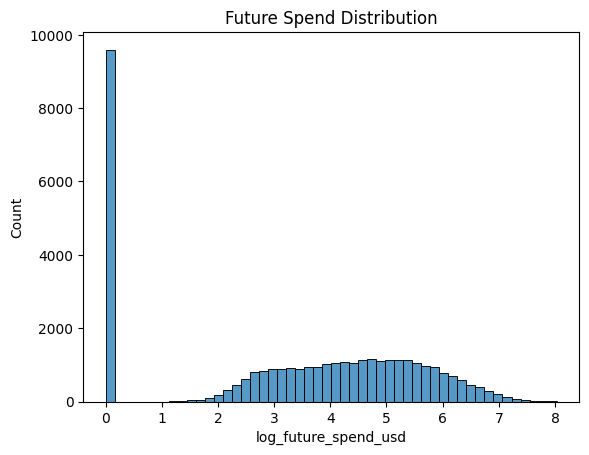

In [223]:
df["log_future_spend_usd"] = np.log1p(df["future_spend_usd"])

plt.figure()
sns.histplot(df["log_future_spend_usd"], bins=50)
plt.title("Future Spend Distribution")
plt.show()

__Grouping buyers and non-buyers based on average transaction activity__

In [224]:
df["will_spend"] = (df["future_spend_usd"] > 0 ).astype(int)

df.groupby("will_spend")[[
    "transaction_count",
    "total_spent_usd",
    "avg_order_value_usd",
    "recency_days",
    "customer_age_days"
]].mean()

,transaction_count,total_spent_usd,avg_order_value_usd,recency_days,customer_age_days
will_spend,,,,,
0,1.281322,135.372706,34.662405,146.737232,212.002502
1,8.789257,916.456833,49.059931,43.578363,279.951117


On average:
+ future spenders make about 8x more transactions
+ And have more recent orders (like 100 days more recent) than those that didn't spend later on

In [225]:
df.sample(5)

,customer_id,transaction_count,promo_code_used,quantity,total_spent,avg_order_value,first_purchase_date,last_purchase_date,payment_method_count,future_spend,total_spent_usd,future_spend_usd,avg_order_value_usd,recency_days,customer_age_days,log_future_spend_usd,will_spend
26959,74502,1,0,1,369065.0,369065.000000,2021-08-17 21:38:00,2021-08-17 21:38:00,1,310057.0,21.984,18.469,21.984,136,136,2.968823,1
20158,55538,12,2,21,15405664.0,855870.222222,2021-01-04 00:11:00,2021-12-22 01:49:00,2,2630482.0,917.684,156.693,50.982,9,361,5.060650,1
30125,83519,37,6,52,21125743.0,480130.522727,2021-01-01 05:48:00,2021-12-27 15:59:00,4,11916833.0,1258.418,709.862,28.600,4,364,6.566478,1
31475,87195,2,0,6,3544408.0,886102.000000,2021-07-26 11:25:00,2021-11-27 19:03:00,1,144292.0,211.133,8.595,52.783,34,158,2.261242,1
2776,7372,4,4,9,4077490.0,679581.666667,2021-02-09 19:13:00,2021-11-03 17:45:00,1,504463.0,242.888,30.050,40.481,58,325,3.435599,1


In [226]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36086 entries, 0 to 36085
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           36086 non-null  int64         
 1   transaction_count     36086 non-null  int64         
 2   promo_code_used       36086 non-null  int64         
 3   quantity              36086 non-null  int64         
 4   total_spent           36086 non-null  float64       
 5   avg_order_value       36086 non-null  float64       
 6   first_purchase_date   36086 non-null  datetime64[us]
 7   last_purchase_date    36086 non-null  datetime64[us]
 8   payment_method_count  36086 non-null  int64         
 9   future_spend          36086 non-null  float64       
 10  total_spent_usd       36086 non-null  float64       
 11  future_spend_usd      36086 non-null  float64       
 12  avg_order_value_usd   36086 non-null  float64       
 13  recency_days          36086